In [ ]:
def evaluate(battery_swap_schedule):
    total_score = 0
    for ev_id, sched in battery_swap_schedule.items():
        if sched and sched.get("assigned"):
            beg = (sched["received_battery"] * (1 - 0.00025 * sched["received_battery_cycle"])) - (sched["exchanged_battery"] * (1 - 0.00025 * sched["exchanged_battery_cycle"])) 
            total_score = total_score + ((0.75 * beg) - (0.25 * sched["waiting_time"]))

    return total_score

In [ ]:
import copy

def queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold=80):
    slot_timeline = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    swaps = []
    temp_queue = {}

    for ev_id, data in ev.items():
        sched = copy.deepcopy(data.get('swap_schedule'))
        if sched and sched.get('assigned'):
            key = (sched['battery_station'], sched['slot'])
            ready_time = sched['travel_time'] + sched['waiting_time']
            exchanged_battery = sched['exchanged_battery']
            exchanged_battery_cycle = sched['battery_cycle']

            if key not in temp_queue:
                temp_queue[key] = [(ready_time, exchanged_battery, exchanged_battery_cycle)]
            else:
                temp_queue[key].append((ready_time, exchanged_battery, exchanged_battery_cycle))

    slot_timeline = {
        key: sorted(entries, key=lambda x: x[0])
        for key, entries in temp_queue.items()
    }

    for ev_id, sched in solution.items():
        if sched['assigned'] and not ev[ev_id]['swap_schedule']:
            arrival_time = sched['travel_time']
            key = (sched['battery_station'], sched['slot'])
            swaps.append((arrival_time, ev_id, key))

    swaps.sort()

    for _, ev_id, key in swaps:
        sched = solution[ev_id]
        station_idx, slot_idx = key

        if key not in slot_timeline:
            last_ready_time = 0
            last_insert = battery_swap_station[station_idx][slot_idx][0]
            last_insert_cycle = battery_swap_station[station_idx][slot_idx][1]
        else:
            last_ready_time, last_insert, last_insert_cycle = slot_timeline[key][-1]

        arrival_time = sched['travel_time']
        time_to_80 = max(0, (required_battery_threshold - last_insert) / charging_rate)
        ready_time = last_ready_time + time_to_80
        waiting_time = max(0, ready_time - arrival_time)

        exchanged_battery = sched['exchanged_battery']
        received_battery = min(100, last_insert + (arrival_time + waiting_time - last_ready_time) * charging_rate)
        exchanged_battery_cycle = sched['battery_cycle']
        received_battery_cycle = last_insert_cycle + (received_battery - last_insert) / 100

        solution[ev_id]['waiting_time'] = round(waiting_time, 2)
        solution[ev_id]['received_battery'] = round(received_battery, 2)
        solution[ev_id]['received_battery_cycle'] = round(received_battery_cycle, 2)

        if key not in slot_timeline:
            slot_timeline[key] = [(arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle)]
        else:
            slot_timeline[key].append((arrival_time + waiting_time, exchanged_battery, exchanged_battery_cycle))

    return solution

In [ ]:
import random

def random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold=80):
    solution = {}
    station_batteries = copy.deepcopy(battery_swap_station)

    for i, data in ev.items():
        if data['swap_schedule']:
            solution[i] = copy.deepcopy(data['swap_schedule'])

    candidates = []
    for i, data in ev.items():
        if data['swap_schedule']:
            continue

        if data['battery_now'] <= 40:
            energy_to_nearest = min(data['energy_distance'])
            if (data['battery_now'] * (100 - data['battery_cycle'] * 0.025)/100) - energy_to_nearest < threshold:
                candidates.append(i)
        else:
            solution[i] = {
                'assigned': False,
                'swap_id': None,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': None,
                'slot': None,
                'energy_distance': None,
                'travel_time': None,
                'waiting_time': None,
                'exchanged_battery': None,
                'received_battery': None,
                'exchanged_battery_cycle': None,
                'received_battery_cycle': None,
                'status': None,
                'scheduled_time': None,
            }
            continue

    random.shuffle(candidates)

    slot_keys = [(i, j) for i in range(len(battery_swap_station)) for j in range(len(battery_swap_station[i]))]
    slot_usage = {k: [] for k in slot_keys}

    for i in candidates:
        data = ev[i]
        valid_options = []

        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if (data['battery_now'] * (100 - data['battery_cycle'] * 0.025)/100) - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                valid_options.append((station_idx, slot_idx, ed, tt))

        if not valid_options:
            solution[i] = {
                'assigned': False,
                'swap_id': None,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': None,
                'slot': None,
                'energy_distance': None,
                'travel_time': None,
                'waiting_time': None,
                'exchanged_battery': None,
                'received_battery': None,
                'exchanged_battery_cycle': None,
                'received_battery_cycle': None,
                'status': None,
                'scheduled_time': None,
            }
            continue

        station_idx, slot_idx, energy_dist, travel_time = random.choice(valid_options)
        key = (station_idx, slot_idx)
        degradation_factor = 1 + (0.00025 * data['battery_cycle'])

        exchanged_battery = data['battery_now'] - energy_dist * degradation_factor

        solution[i] = {
            'assigned': True,
            'swap_id': None,
            'battery_now': data['battery_now'],
            'battery_cycle': data['battery_cycle'],
            'battery_station': station_idx,
            'slot': slot_idx,
            'energy_distance': energy_dist,
            'travel_time': travel_time,
            'waiting_time': 0,
            'exchanged_battery': exchanged_battery,
            'received_battery': 0,
            'exchanged_battery_cycle': data['battery_cycle'],
            'received_battery_cycle': 0,
            'status': 'on going',
            'scheduled_time': None,
        }

    solution = queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)
    return solution

In [ ]:
import math

def random_destroy(solution, ev, destroy_ratio=0.1):
    destroyed = copy.deepcopy(solution)
    keys = [k for k in destroyed if destroyed[k].get("assigned") and not ev[k].get("swap_schedule")]

    if not keys:
        return destroyed, []

    upper_bound = max(1, int(len(keys) * destroy_ratio))
    num_remove = random.randint(1, upper_bound)
    to_remove = random.sample(keys, num_remove)

    return destroyed, to_remove

def destroy_high_waiting_time(solution, ev, destroy_ratio=0.1):
    destroyed = copy.deepcopy(solution)
    
    keys = [
        k for k in destroyed 
        if destroyed[k].get("assigned") 
        and not ev[k].get("swap_schedule") 
        and destroyed[k].get("waiting_time") is not None
    ]

    if not keys:
        return destroyed, []

    sorted_keys = sorted(keys, key=lambda k: destroyed[k]["waiting_time"], reverse=True)

    upper_bound = max(1, int(len(sorted_keys) * destroy_ratio))
    num_remove = random.randint(1, upper_bound)
    to_remove = sorted_keys[:num_remove]

    return destroyed, to_remove

def random_repair(solution, ev, battery_swap_station, charging_rate, required_battery_threshold, to_remove):
    for target_ev in to_remove:
        data = ev[target_ev]

        valid_options = []
        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if (data['battery_now'] * (100 - data['battery_cycle'] * 0.025)/100) - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                valid_options.append((station_idx, slot_idx, ed, tt))
        if valid_options:
            station_idx, slot_idx, ed, tt = random.choice(valid_options)

            degradation_factor = 1 + (0.00025 * data['battery_cycle'])
            exchanged_battery = data['battery_now'] - ed * degradation_factor
            solution[target_ev] = {
                'assigned': True,
                'swap_id': None,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': station_idx,
                'slot': slot_idx,
                'energy_distance': ed,
                'travel_time': tt,
                'waiting_time': 0,
                'exchanged_battery': exchanged_battery,
                'received_battery': 0,
                'exchanged_battery_cycle': data['battery_cycle'],
                'received_battery_cycle': 0,
                'status': 'on going',
                'scheduled_time': None,
            }

    return queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)

def available_repair(solution, ev, battery_swap_station, charging_rate, required_battery_threshold, to_remove):
    used_slots = set(
        (sched['battery_station'], sched['slot'])
        for ev_id, sched in solution.items()
        if sched.get("assigned") and sched['battery_station'] is not None and sched['slot'] is not None
    )

    for target_ev in to_remove:
        data = ev[target_ev]
        valid_options = []

        for station_idx, (ed, tt) in enumerate(zip(data['energy_distance'], data['travel_time'])):
            if (data['battery_now'] * (100 - data['battery_cycle'] * 0.025)/100) - ed < 0:
                continue
            for slot_idx in range(len(battery_swap_station[station_idx])):
                key = (station_idx, slot_idx)
                if key not in used_slots:
                    valid_options.append((station_idx, slot_idx, ed, tt))

        if valid_options:
            station_idx, slot_idx, ed, tt = random.choice(valid_options)

            degradation_factor = 1 + (0.00025 * data['battery_cycle'])
            exchanged_battery = data['battery_now'] - ed * degradation_factor
            solution[target_ev] = {
                'assigned': True,
                'swap_id': None,
                'battery_now': data['battery_now'],
                'battery_cycle': data['battery_cycle'],
                'battery_station': station_idx,
                'slot': slot_idx,
                'energy_distance': ed,
                'travel_time': tt,
                'waiting_time': 0,
                'exchanged_battery': exchanged_battery,
                'received_battery': 0,
                'exchanged_battery_cycle': data['battery_cycle'],
                'received_battery_cycle': 0,
                'status': 'on going',
                'scheduled_time': None,
            }
            used_slots.add((station_idx, slot_idx))

    return queue_update(solution, ev, battery_swap_station, charging_rate, required_battery_threshold)


def roulette_select(weights):
    total = sum(weights)
    r = random.uniform(0, total)
    upto = 0
    for i, w in enumerate(weights):
        if upto + w >= r:
            return i
        upto += w
    return len(weights) - 1


def normalize_scores(scores):
    total = sum(scores)
    return [s / total if total > 0 else 1.0 for s in scores]


def alns_ev_scheduler(
    battery_swap_station,
    ev,
    threshold,
    charging_rate,
    required_battery_threshold=80,
    max_iter=1000
):
    current = random_initialization(battery_swap_station, ev, threshold, charging_rate, required_battery_threshold)
    best = copy.deepcopy(current)
    best_score = evaluate(best)
    T = 1.0

    destroy_ops = [random_destroy, destroy_high_waiting_time]
    repair_ops = [random_repair, available_repair]
    destroy_weights = [1.0]
    repair_weights = [1.0]

    destroy_scores = [0.0 for _ in destroy_ops]
    repair_scores = [0.0 for _ in repair_ops]
    history = []

    for it in range(max_iter):
        destroy_idx = roulette_select(destroy_weights)
        repair_idx = roulette_select(repair_weights)

        destroyed, to_remove = destroy_ops[destroy_idx](current, ev)

        repaired = repair_ops[repair_idx](destroyed, ev, battery_swap_station, charging_rate, required_battery_threshold, to_remove)

        score = evaluate(repaired)

        if score > best_score:
            best = copy.deepcopy(repaired)
            best_score = score
            destroy_scores[destroy_idx] += 2
            repair_scores[repair_idx] += 2
            current = copy.deepcopy(best)
        else:
            destroy_scores[destroy_idx] -= 1
            repair_scores[repair_idx] -= 1

        if (it + 1) % 50 == 0:
            destroy_weights = [1.0]
            repair_weights = [1.0]
            destroy_scores = [0.0 for _ in destroy_ops]
            repair_scores = [0.0 for _ in repair_ops]

        print(f"[{it}] Best score: {best_score}")
        history.append(best_score)

    return best, best_score, history

In [ ]:
import pickle

with open("ev_battery_swap_random_dataset.pkl", "rb") as f:
    battery_swap_station_demo, ev_demo = pickle.load(f)

solution, fitness, history = alns_ev_scheduler(
    battery_swap_station=battery_swap_station_demo,
    ev=ev_demo,
    threshold=15,
    charging_rate=100 / 240,
    required_battery_threshold=80,
    max_iter=1000
)

[0] Best score: -7934.7769330156225
[1] Best score: -7653.623188409375
[2] Best score: -7653.623188409375
[3] Best score: -7649.381628034374
[4] Best score: -7562.922782221876
[5] Best score: -7436.860282221875
[6] Best score: -7436.860282221875
[7] Best score: -7436.860282221875
[8] Best score: -7436.860282221875
[9] Best score: -7436.860282221875
[10] Best score: -7436.860282221875
[11] Best score: -7436.860282221875
[12] Best score: -7436.860282221875
[13] Best score: -7436.860282221875
[14] Best score: -7436.860282221875
[15] Best score: -7436.860282221875
[16] Best score: -7436.860282221875
[17] Best score: -7423.449874781252
[18] Best score: -7423.449874781252
[19] Best score: -7423.449874781252
[20] Best score: -7350.28995928125
[21] Best score: -7350.28995928125
[22] Best score: -7350.28995928125
[23] Best score: -7350.28995928125
[24] Best score: -7350.28995928125
[25] Best score: -7341.874959281251
[26] Best score: -7341.874959281251
[27] Best score: -7341.874959281251
[28] B

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt


def plot_distributions_2(initial_temp=100, num_of_cycle=100, runs=1000, max_attempts=1000):
    fitness_values = []
    duration_values = []
    valid_runs = 0
    
    print(f"Running {runs} trials of improved GWO...")
    
    for i in range(runs):
        if i % 100 == 0 and i > 0:
            print(f"Completed {i} runs...")
            
        start_time = time.time()
        
        solution, fitness, history = alns_ev_scheduler(
            battery_swap_station=battery_swap_station_demo,
            ev=ev_demo,
            threshold=15,
            charging_rate=100 / 240,
            required_battery_threshold=80,
            max_iter=1000
        )
                
        end_time = time.time()
        duration = end_time - start_time
        duration_values.append(duration)
        
        if solution is not None and fitness is not None:
            fitness_values.append(fitness)
            valid_runs += 1
    
    print(f"Valid solutions: {valid_runs}/{runs} ({valid_runs/runs*100:.2f}%)")
    
    if fitness_values:
        mean_fitness = np.mean(fitness_values)
        std_fitness = np.std(fitness_values)
        
        plt.figure(figsize=(8, 6))
        plt.hist(fitness_values, bins=20, edgecolor='black')
        plt.axvline(mean_fitness, linestyle='--', label=f'Mean = {mean_fitness:.2f}')
        plt.axvline(mean_fitness + std_fitness, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_fitness:.2f}')
        plt.axvline(mean_fitness - std_fitness, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_fitness:.2f}')
        plt.title('Distribution of Best Fitness over {} Runs'.format(valid_runs))
        plt.xlabel('Fitness')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean fitness: {mean_fitness:.4f}")
        print(f"Std deviation of fitness: {std_fitness:.4f}")
    else:
        mean_fitness = None
        std_fitness = None
        print("No valid solutions found to plot fitness distribution")
    
    if duration_values:
        mean_duration = np.mean(duration_values)
        std_duration = np.std(duration_values)

        plt.figure(figsize=(8, 6))
        plt.hist(duration_values, bins=20, edgecolor='black')
        plt.axvline(mean_duration, linestyle='--', label=f'Mean = {mean_duration:.4f}s')
        plt.axvline(mean_duration + std_duration, color='gray', linestyle=':', 
                    label=f'+1 Std = {std_duration:.4f}s')
        plt.axvline(mean_duration - std_duration, color='gray', linestyle=':', 
                    label=f'-1 Std = {std_duration:.4f}s')
        plt.title('Distribution of Computation Time over {} Runs'.format(runs))
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency')
        plt.legend()
        plt.tight_layout()
        plt.show()
        
        print(f"Mean computation time: {mean_duration:.4f} seconds")
        print(f"Std deviation of time: {std_duration:.4f} seconds")
    else:
        mean_duration = None
        std_duration = None
        print("No runs completed to plot duration distribution")
    
    return mean_fitness, std_fitness, mean_duration, std_duration

Running 100 trials of improved GWO...
[0] Best score: -7761.807164134373
[1] Best score: -7761.807164134373
[2] Best score: -7761.807164134373
[3] Best score: -7761.807164134373
[4] Best score: -7728.206203134375
[5] Best score: -7728.206203134375
[6] Best score: -7726.525668759376
[7] Best score: -7655.998536696875
[8] Best score: -7655.998536696875
[9] Best score: -7597.389146040626
[10] Best score: -7597.389146040626
[11] Best score: -7597.389146040626
[12] Best score: -7597.389146040626
[13] Best score: -7597.389146040626
[14] Best score: -7597.389146040626
[15] Best score: -7597.389146040626
[16] Best score: -7448.812794587499
[17] Best score: -7448.812794587499
[18] Best score: -7448.812794587499
[19] Best score: -7304.940826734377
[20] Best score: -7304.940826734377
[21] Best score: -7304.940826734377
[22] Best score: -7156.754643640626
[23] Best score: -7156.754643640626
[24] Best score: -7156.754643640626
[25] Best score: -7156.754643640626
[26] Best score: -7156.754643640626


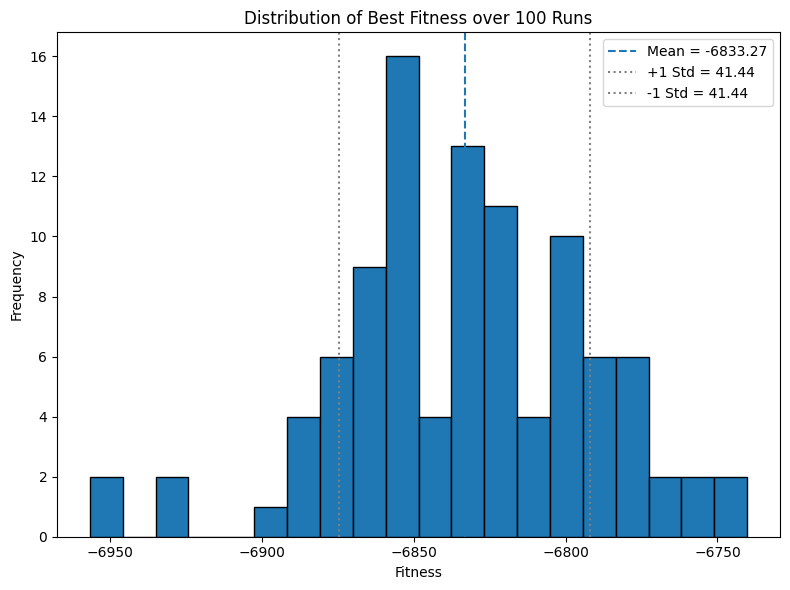

Mean fitness: -6833.2741
Std deviation of fitness: 41.4381


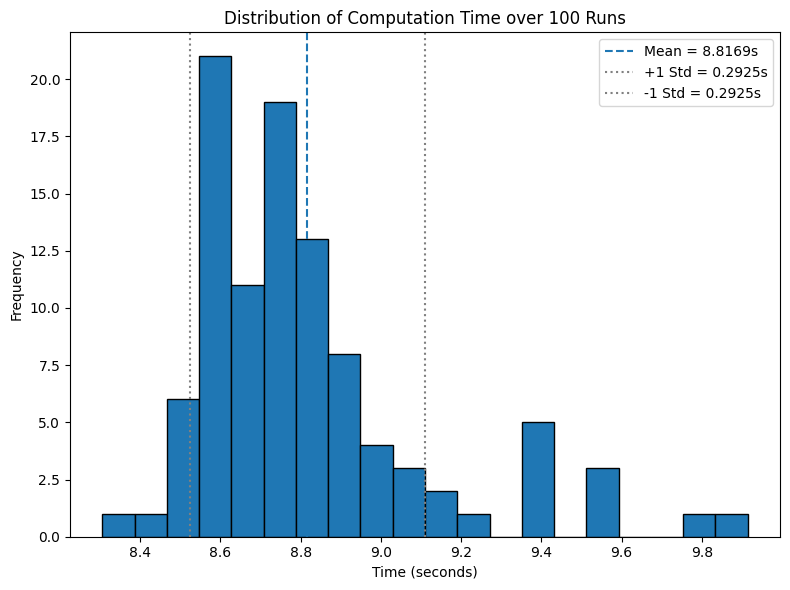

Mean computation time: 8.8169 seconds
Std deviation of time: 0.2925 seconds


(np.float64(-6833.274077059501),
 np.float64(41.438101101444616),
 np.float64(8.816935608386993),
 np.float64(0.29247763118929543))

In [7]:
plot_distributions_2(initial_temp=100, num_of_cycle=300, runs=100, max_attempts=10)